# Clone my driving behavior

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Lambda, Dropout, Cropping2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

In [2]:
user = !whoami
user = user[0]

In [282]:
IMAGE_SHAPE = (80, 320, 3)
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'

## Load images and measurements

In [103]:
def load_images_and_measurements(image_set_directory, smoothen=1):
    driving_log = (
        pd.read_csv(
            f'./my-videos-center/{image_set_directory}/driving_log.csv', 
            header=None,
            names=[
                'center_image', 'left_image', 'right_image', 
                'steering_angle', 'throttle', 'break', 'speed'])
        .assign(
            center_image=lambda df: 
                PROJECT_DIR 
                + f'/my-videos-center/{image_set_directory}/IMG/' 
                + df['center_image'].str.split('IMG').str[1]))
    
    raw_images = np.stack(driving_log['center_image'].map(plt.imread), axis=0)
    flipped_images = np.flip(raw_images, axis=2)

    images = np.vstack([raw_images, flipped_images])
    
    raw_measurements = driving_log['steering_angle']
    measurements_flipped = - raw_measurements

    measurements = np.hstack([raw_measurements, measurements_flipped])
    
    smooth_measurements = pd.Series(measurements).rolling(smoothen, min_periods=1, center=True).mean()
    
    return images, smooth_measurements

In [27]:
def load_image_sets(image_set_names, smoothen=1):
    image_sets, measure_sets = zip(*[load_images_and_measurements(name, smoothen) for name in image_set_names])
    
    return np.vstack(image_sets), np.hstack(measure_sets)

In [133]:
%%time
images, measurements = load_image_sets([
#     'first_drives', 
#     '3_forward_rounds', 
#     '3_backward_rounds',
#     'edges_forward',
#     'edges_backward',
    'edges_smooth',
#     '2_rounds_for_testing',
#     '3_more_fw_rounds',
#     '3_more_bw_rounds',
#     'driving_on_the_edge_fw_left',
#     'driving_on_the_edge_fw_right',
#     '1_round_fw_hard_level'
], smoothen=10)

print(f'Number of samples: {measurements.shape[0]}')

Number of samples: 1718
CPU times: user 2.34 s, sys: 504 ms, total: 2.84 s
Wall time: 2.85 s


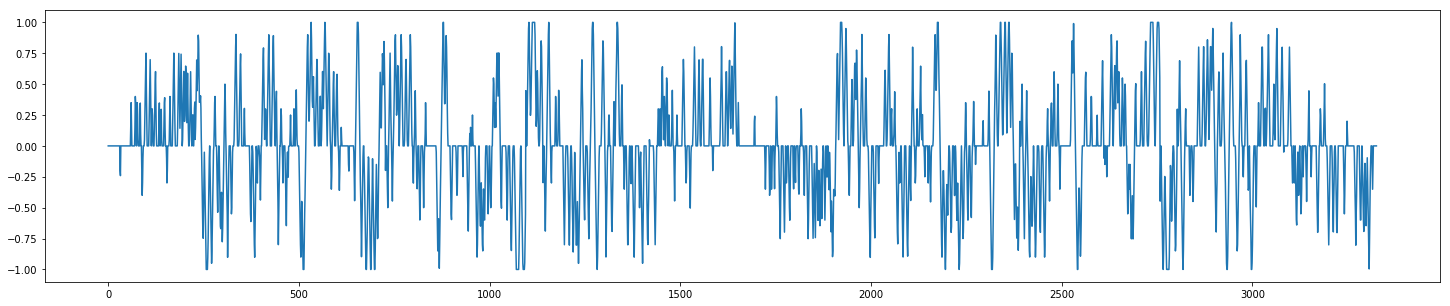

In [111]:
_, measurements_non_smooth = load_image_sets(['1_round_fw_hard_level'], smoothen=1)

plt.figure(figsize=(25, 5))
plt.plot(measurements_non_smooth)
plt.show()

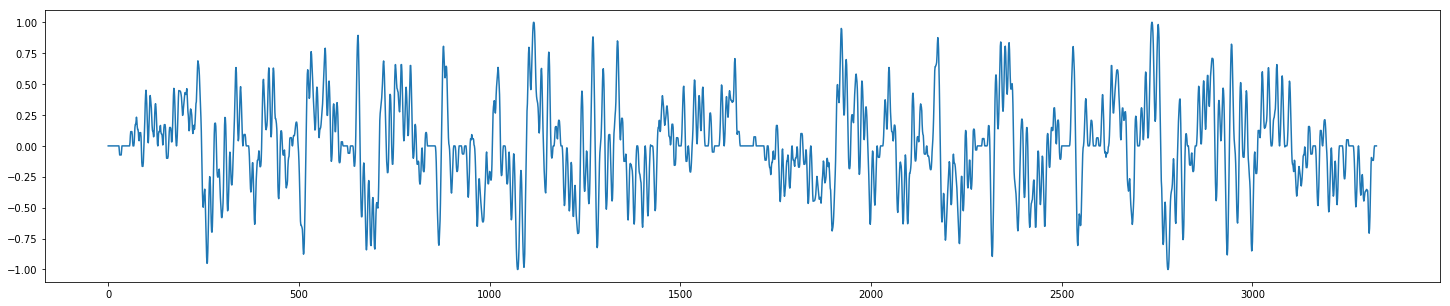

In [112]:
_, measurements_smooth = load_image_sets(['1_round_fw_hard_level'], smoothen=6)

plt.figure(figsize=(25, 5))
plt.plot(measurements_smooth)
plt.show()

In [134]:
seed = 4363
train_images, valid_images, train_meas, valid_meas = train_test_split(images, measurements, test_size=0.1, random_state=seed)

print(f'Number of training samples: {train_meas.shape[0]}')
print(f'Number of training samples: {valid_meas.shape[0]}')

Number of training samples: 1546
Number of training samples: 172


In [334]:
np.random.randint(2) == 0

False

In [339]:
np.random.randint(2, size=10).astype(bool)

array([False,  True,  True, False, False,  True,  True,  True, False,
       False])

In [408]:
def random_vertical_flip():
    """Flips the images with a probability of 0.5.
    
    Returns:
        a transform which performs the flips
    """
    def random_flip(images, angles):
        flip = np.random.randint(2, size=angles.shape[0]).astype(bool)
        flipped_images = np.where(flip.reshape(angles.shape[0], 1, 1, 1), np.flip(images, axis=2), images)
        flipped_angles = np.where(flip, - angles, angles)
        return flipped_images, flipped_angles
    
    return random_flip

In [409]:
def scale_images(coeff: float = 1/255.0, bias: float = 0.5):
    """Scales images to an interval by applying a linear transform. The default interval is [-0.5, 0.5].
    
    Args:
        coeff: scaling coefficient
        bias: scaling bias
        
    Returns:
        transform function which scales images
    """
    return lambda images, angles: [coeff * images - bias, angles]

In [410]:
def crop_images_vertically(top_crop: int = 60, bottom_crop: int = 20):
    """Crops an image vertically by removing given pixels from the top and bottom.
    
    Args:
        top_crop: pixels to remove from top of image
        bottom_crop: pixels to remove from bottom of image
        
    Return:
        transform function which applies the crop on images
    """
    return lambda images, angles: [images[:, top_crop:(images.shape[1] - bottom_crop),: , :], angles]

assert crop_images_vertically()(np.array([train_images[0]]), None)[0].shape == (1, 80, 320, 3)

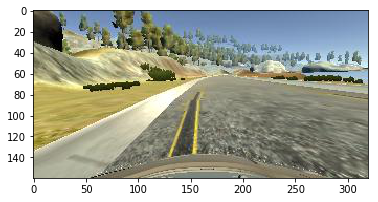

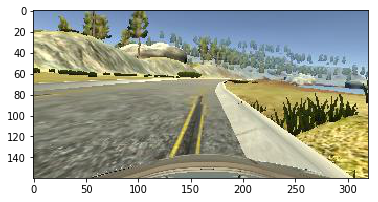

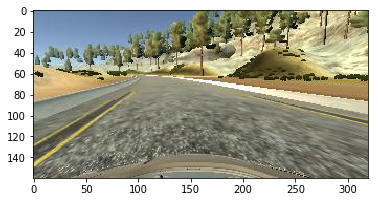

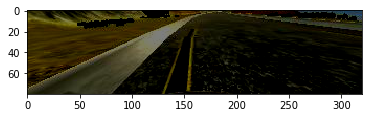

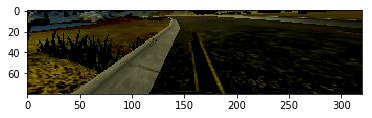

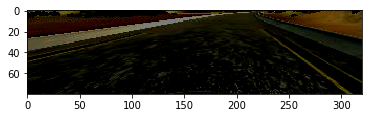

In [420]:
img_ids = [54, 535, 45]

for img in img_ids:
    plt.imshow(train_images[img])
    plt.show()
    
trans_img = transform_images(
    train_images[img_ids], 
    measurements[img_ids], 
    [crop_images_vertically(),
     scale_images(),
     random_vertical_flip()]
)[0]

for img in trans_img:
    plt.imshow(img)
    plt.show()

In [421]:
from functools import reduce
from typing import Callable, Generator, Tuple

def transform_images(images: np.array, measurements: np.array, transforms: Callable[[np.array], np.array]):
    """Applies a list of transforms to all the images and measurements of a given batch.
    
    Args:
        images: array of stacked images
        transforms: list of functions which transform an image
        
    Returns:
        a transformed block of images
    """
    return reduce(lambda acc, nxt: nxt(*acc), transforms, [images, measurements])

In [422]:
def image_generator_from_dataset(images: np.array, measurements: np.array, batch_size: int = 32, augment: bool=False) -> Generator[Tuple[np.array, np.array], None, None]:
    """This generator yields the next training batch
    Args:
        batch_size: number of images generated on each batch
        
    Returns:
        a tuple of features and steering angles as two numpy arrays
    """
    data_size = measurements.shape[0]
    while True:
        sample_idx = np.random.choice(data_size, batch_size)
        image_batch = images[sample_idx]
        measurement_batch = measurements[sample_idx]
        
        yield transform_images(
            image_batch,
            measurement_batch,
            [crop_images_vertically(),
             scale_images(),
             random_vertical_flip()])

In [433]:
test_sample = next(image_generator_from_dataset(images, measurements, batch_size=8, augment=True))
assert test_sample[1].shape == (8, )

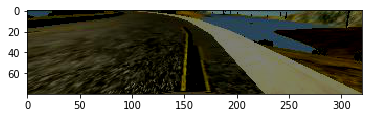

In [436]:
plt.imshow(test_sample[0][5])
plt.show()

In [275]:
# train_datagen = ImageDataGenerator()
# train_generator = train_datagen.flow(train_images, train_meas, batch_size=32)

# fig, axes = plt.subplots(7, 5, figsize=(15, 15))

# for i, image in enumerate(next(train_generator)[0].astype('uint8')):
#     row, col = i // 5, i % 5
#     axes[row, col].axis('off')
#     axes[row, col].imshow(image)
    
# for i in range(32, 35):
#     row, col = i // 5, i % 5
#     fig.delaxes(axes[row, col])

# plt.tight_layout()
# plt.subplots_adjust(top=0.95)
# fig.suptitle('Examples of augmented images')
# plt.subplots_adjust(wspace=.05, hspace=.05)
# plt.show()

## Define model

In [437]:
model = Sequential([
    Conv2D(24, (5, 5), strides=(2, 2), input_shape=IMAGE_SHAPE),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(36, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(48, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(50),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer=Adam(lr=0.0005))

In [438]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 38, 158, 24)       1824      
_________________________________________________________________
batch_normalization_49 (Batc (None, 38, 158, 24)       96        
_________________________________________________________________
activation_49 (Activation)   (None, 38, 158, 24)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 17, 77, 36)        21636     
_________________________________________________________________
batch_normalization_50 (Batc (None, 17, 77, 36)        144       
_________________________________________________________________
activation_50 (Activation)   (None, 17, 77, 36)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 37, 48)         43248     
__________

## Train model

In [439]:
train_generator = image_generator_from_dataset(train_images, train_meas, augment=True)
valid_generator = image_generator_from_dataset(valid_images, valid_meas)

In [ ]:
%%time
steps_per_epoch = int(train_meas.shape[0] / 32)
validation_steps = valid_meas.shape[0]

model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/1
47/48 [============================>.] - ETA: 1s - loss: 0.2308

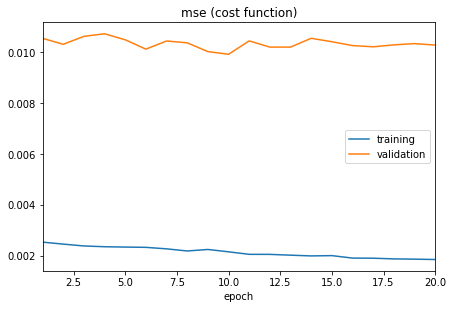

mse (cost function):
training   (min:    0.002, max:    0.003, cur:    0.002)
validation (min:    0.010, max:    0.011, cur:    0.010)
CPU times: user 20min 12s, sys: 9min 39s, total: 29min 51s
Wall time: 26min 5s


In [102]:
%%time
model.fit(
    train_images,
    train_meas,
    epochs=20,
    callbacks=[PlotLossesKeras()],
    validation_data=[valid_images, valid_meas]
)

In [103]:
model.save('./models/model_nvidia_all_datasets_14042019_70_epochs.h5a')

In [104]:
!./upload_models_to_s3.sh

upload: models/model_nvidia_all_datasets_14042019_70_epochs.h5a to s3://behavioral-cloning-models/model_nvidia_all_datasets_14042019_70_epochs.h5a


## Compare original and predicted angle distributions

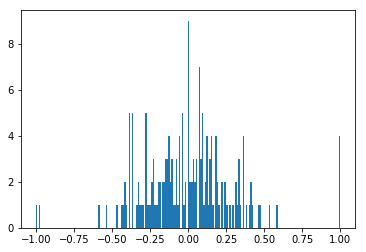

In [12]:
plt.hist(valid_meas, bins=200)
plt.show()

In [106]:
%%time
predictions = model.predict(valid_images)

CPU times: user 2.05 s, sys: 1.68 s, total: 3.73 s
Wall time: 4.73 s


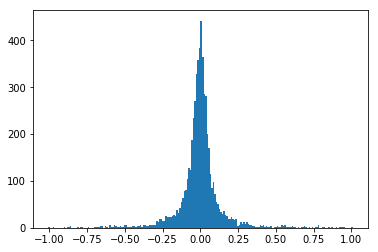

In [107]:
plt.hist(predictions, bins=200)
plt.show()

## Visualize output of convolution layers

In [108]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name or 'cropping2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

In [109]:
def plot_layer_channels(layer, name):
    number_of_channels = layer.shape[2]
    square_size = int(np.ceil(np.sqrt(number_of_channels)))

    fig, axes = plt.subplots(nrows=square_size, ncols=square_size, figsize=(20,20))
    for idx, image in enumerate(layer.transpose(2, 0, 1)):
        row = idx // square_size
        col = idx % square_size
        axes[row, col].axis('off')
        axes[row, col].imshow(image, cmap='gray', aspect='auto')

    for idx in [i for i in range(square_size ** 2) if i >= number_of_channels]:
        row = idx // square_size
        col = idx % square_size
        fig.delaxes(axes[row, col])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f'Channels of layer {name}', fontsize=18)
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

In [110]:
def plot_layers(input_image, evaluation_functions):
    layer_outputs = evaluation_functions([[input_image], 0.])
    
    plt.title('Input image')
    plt.imshow(input_image)
    plt.show()
    
    plt.title('Cropped image')
    plt.imshow(layer_outputs[0][0].astype('uint8'))
    plt.show()
    
    for layer, name in zip(layer_outputs[1:], layer_names[1:]):
        plot_layer_channels(layer[0], name)

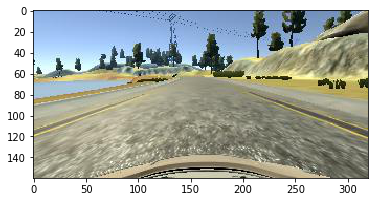

In [111]:
test_image = valid_images[0]
plt.imshow(test_image)
plt.show()

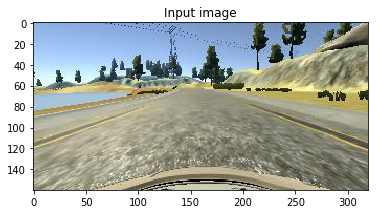

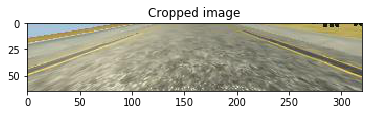

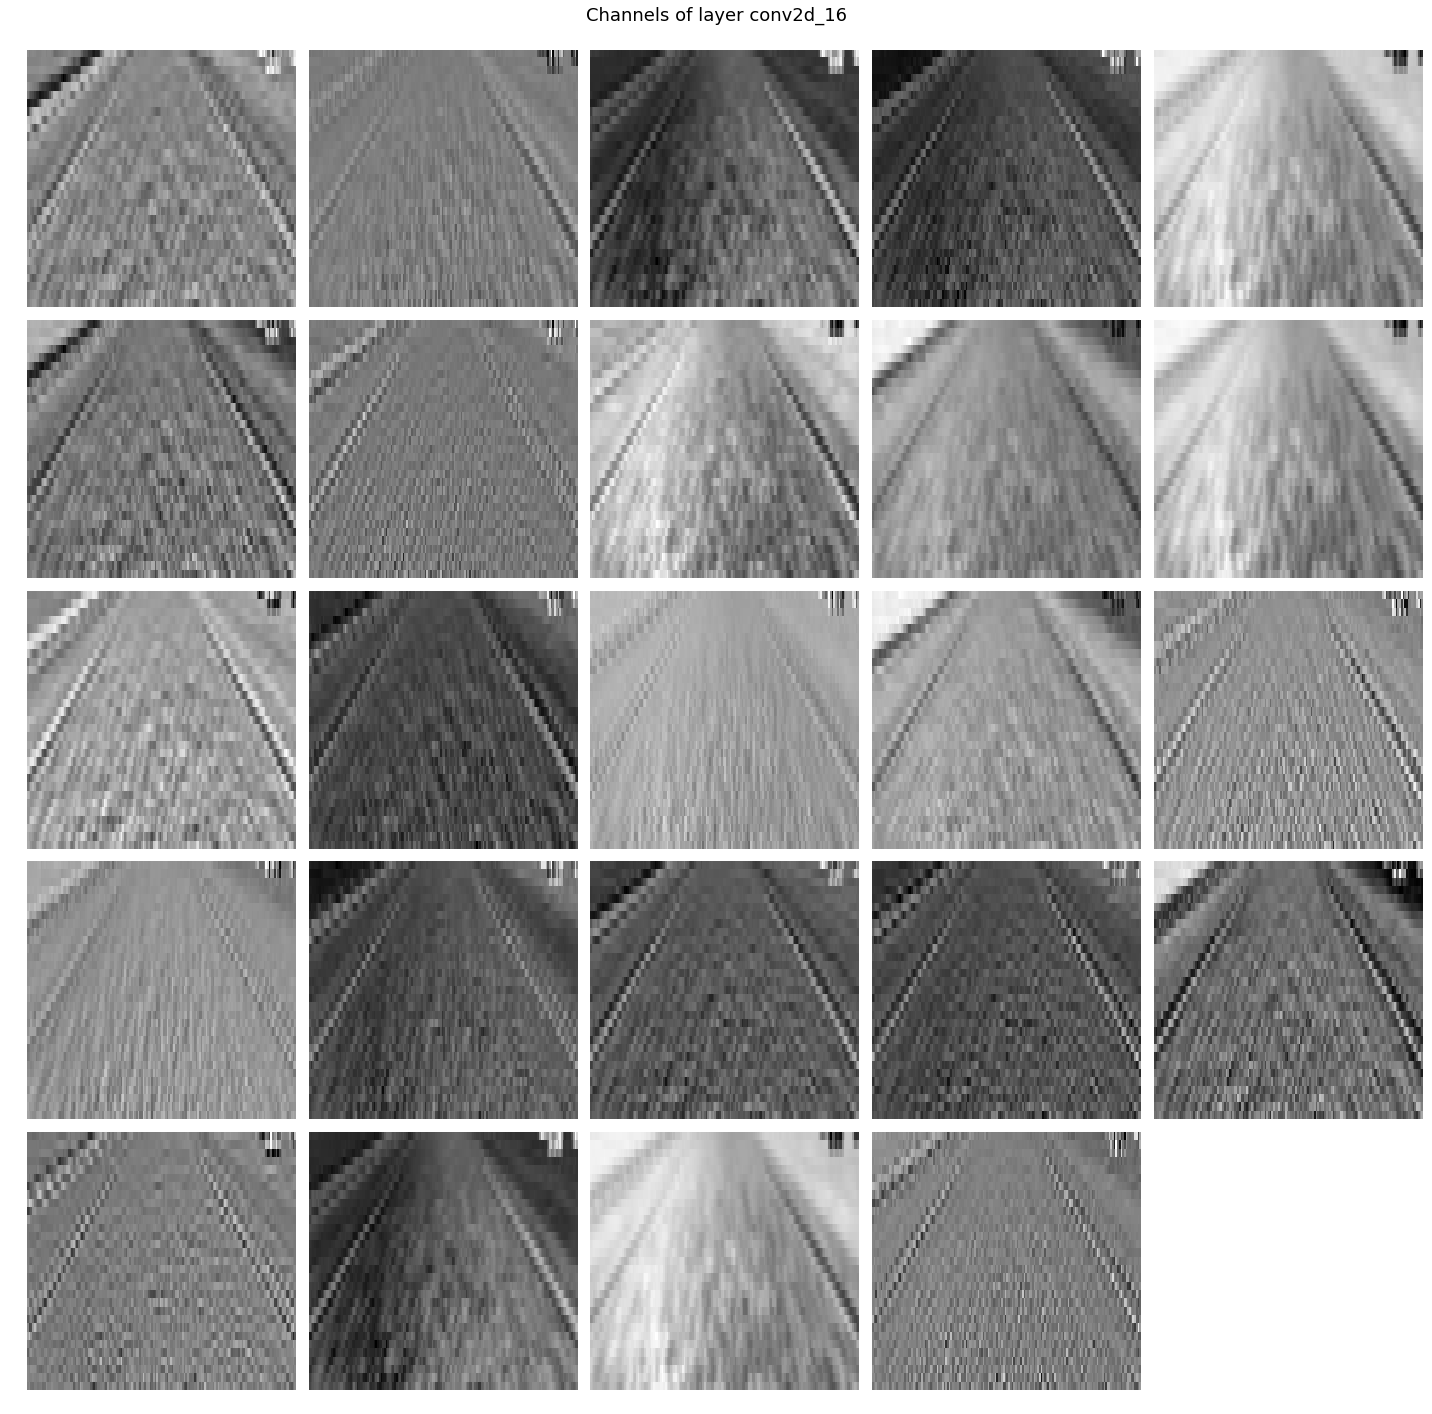

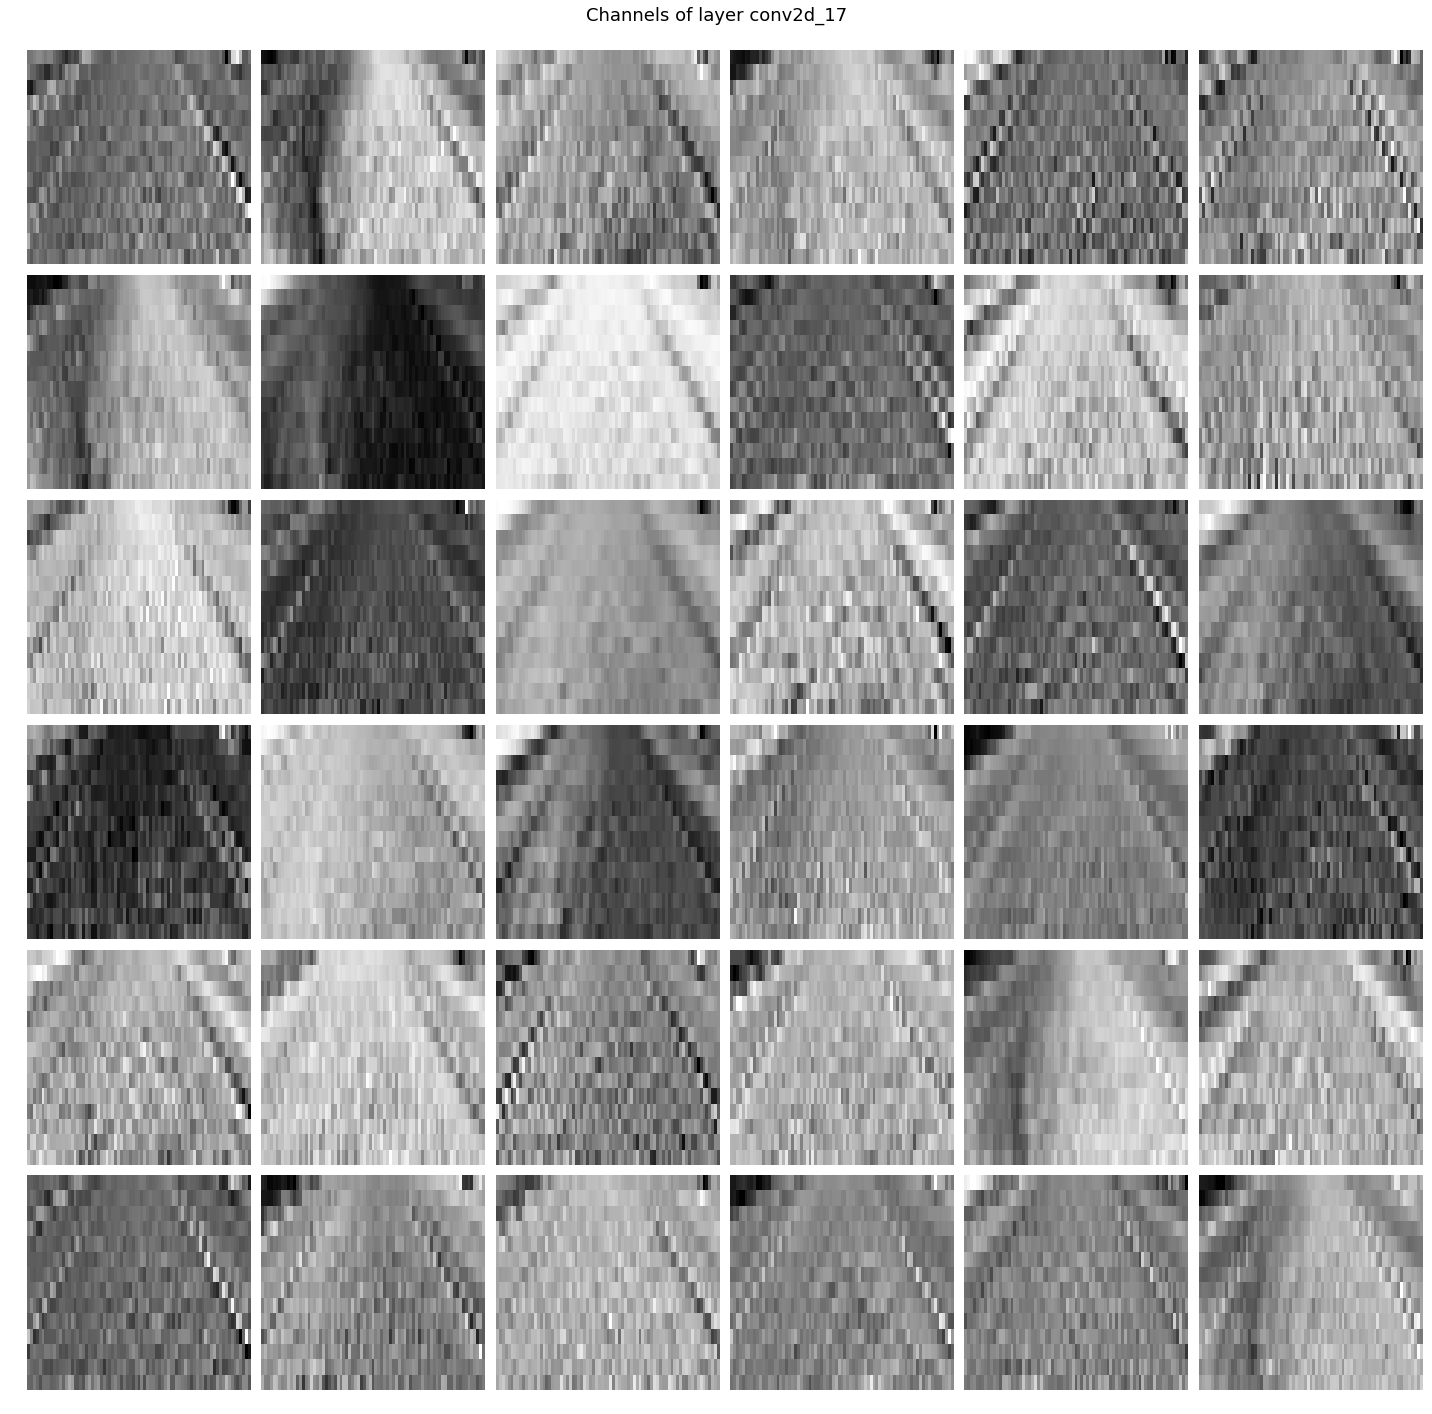

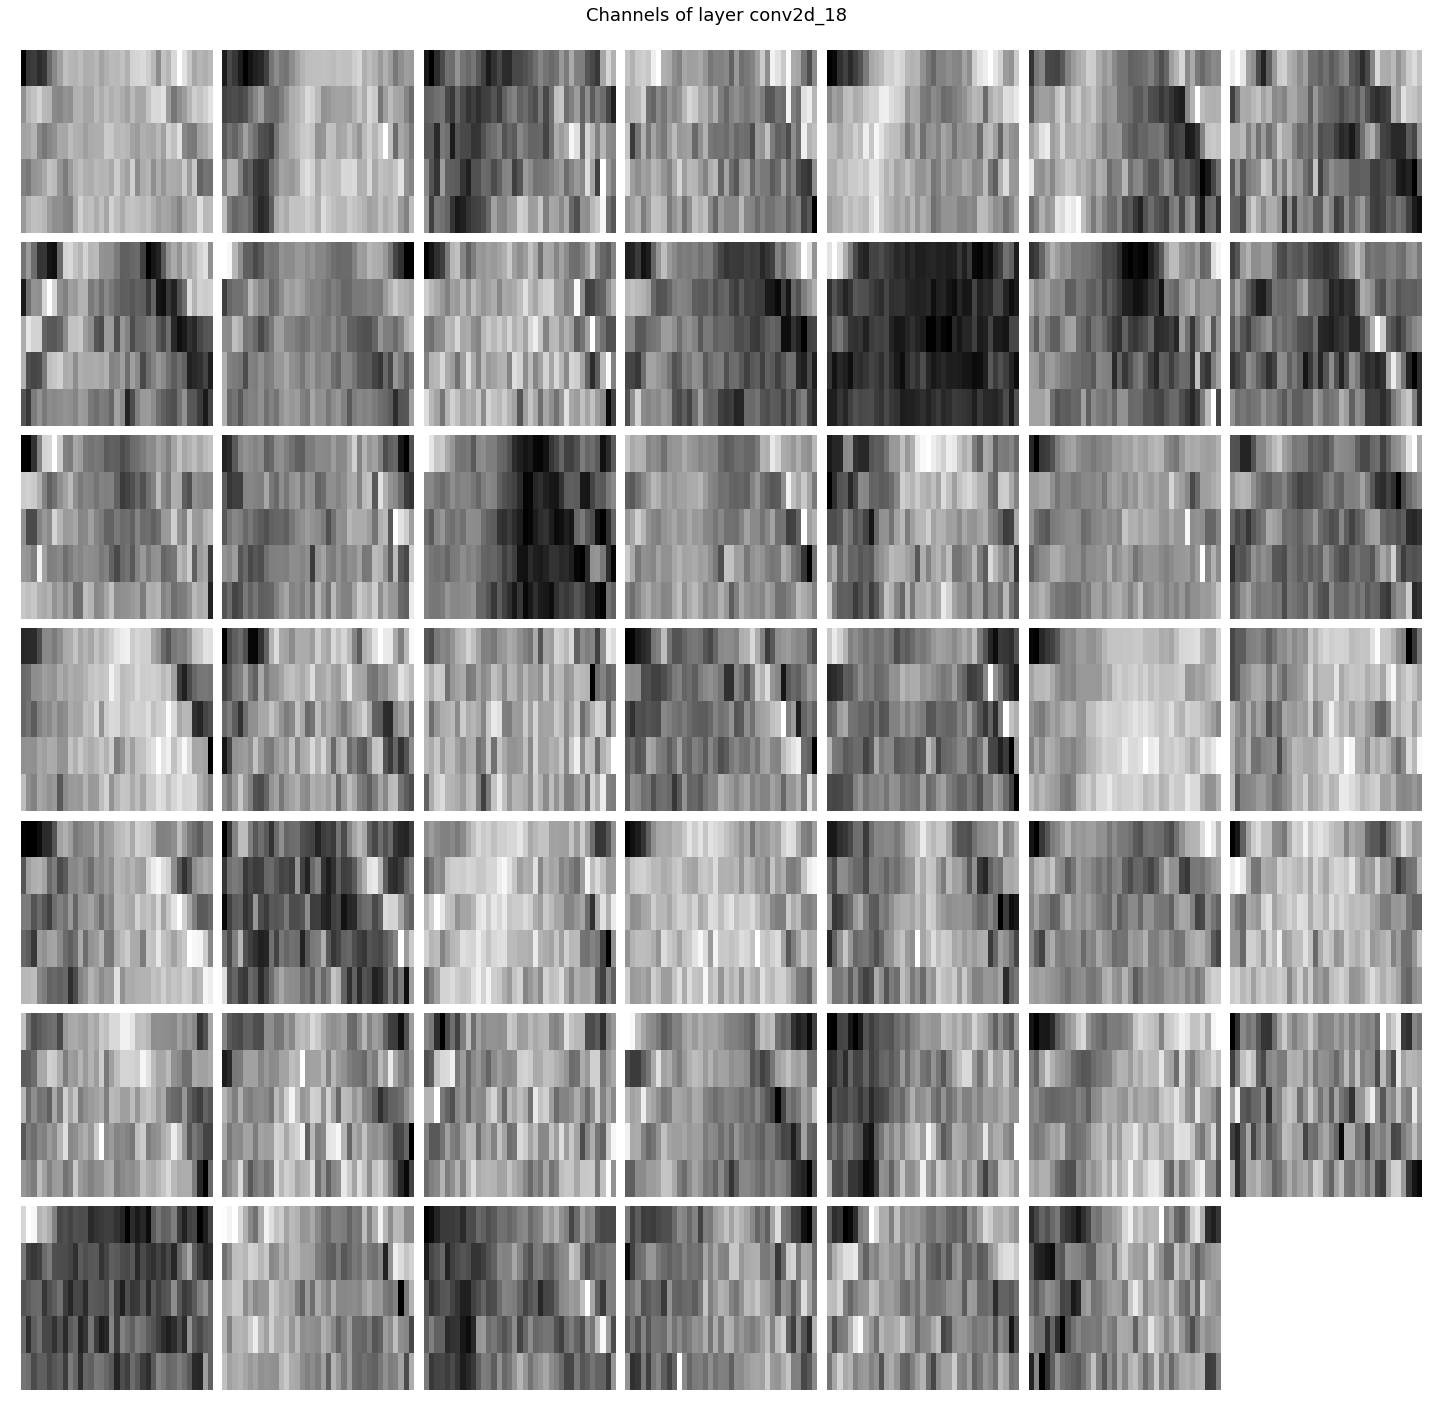

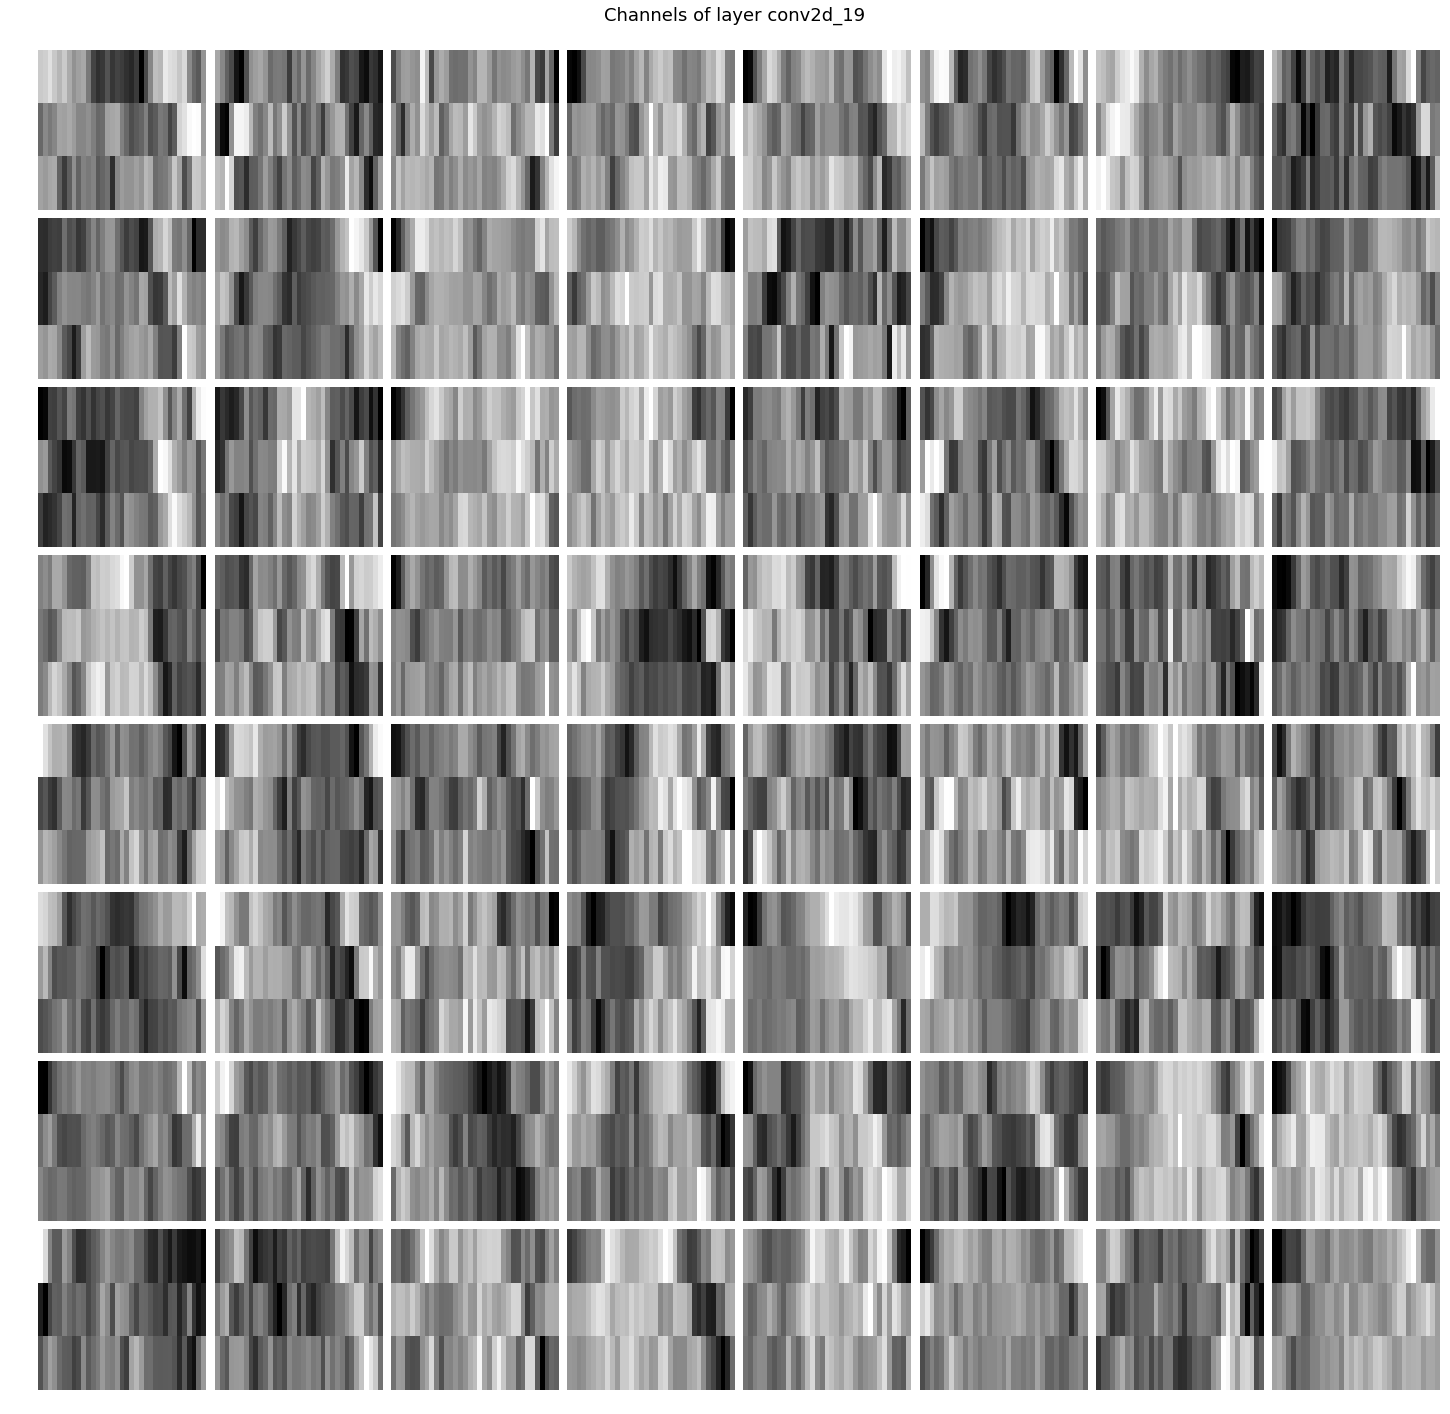

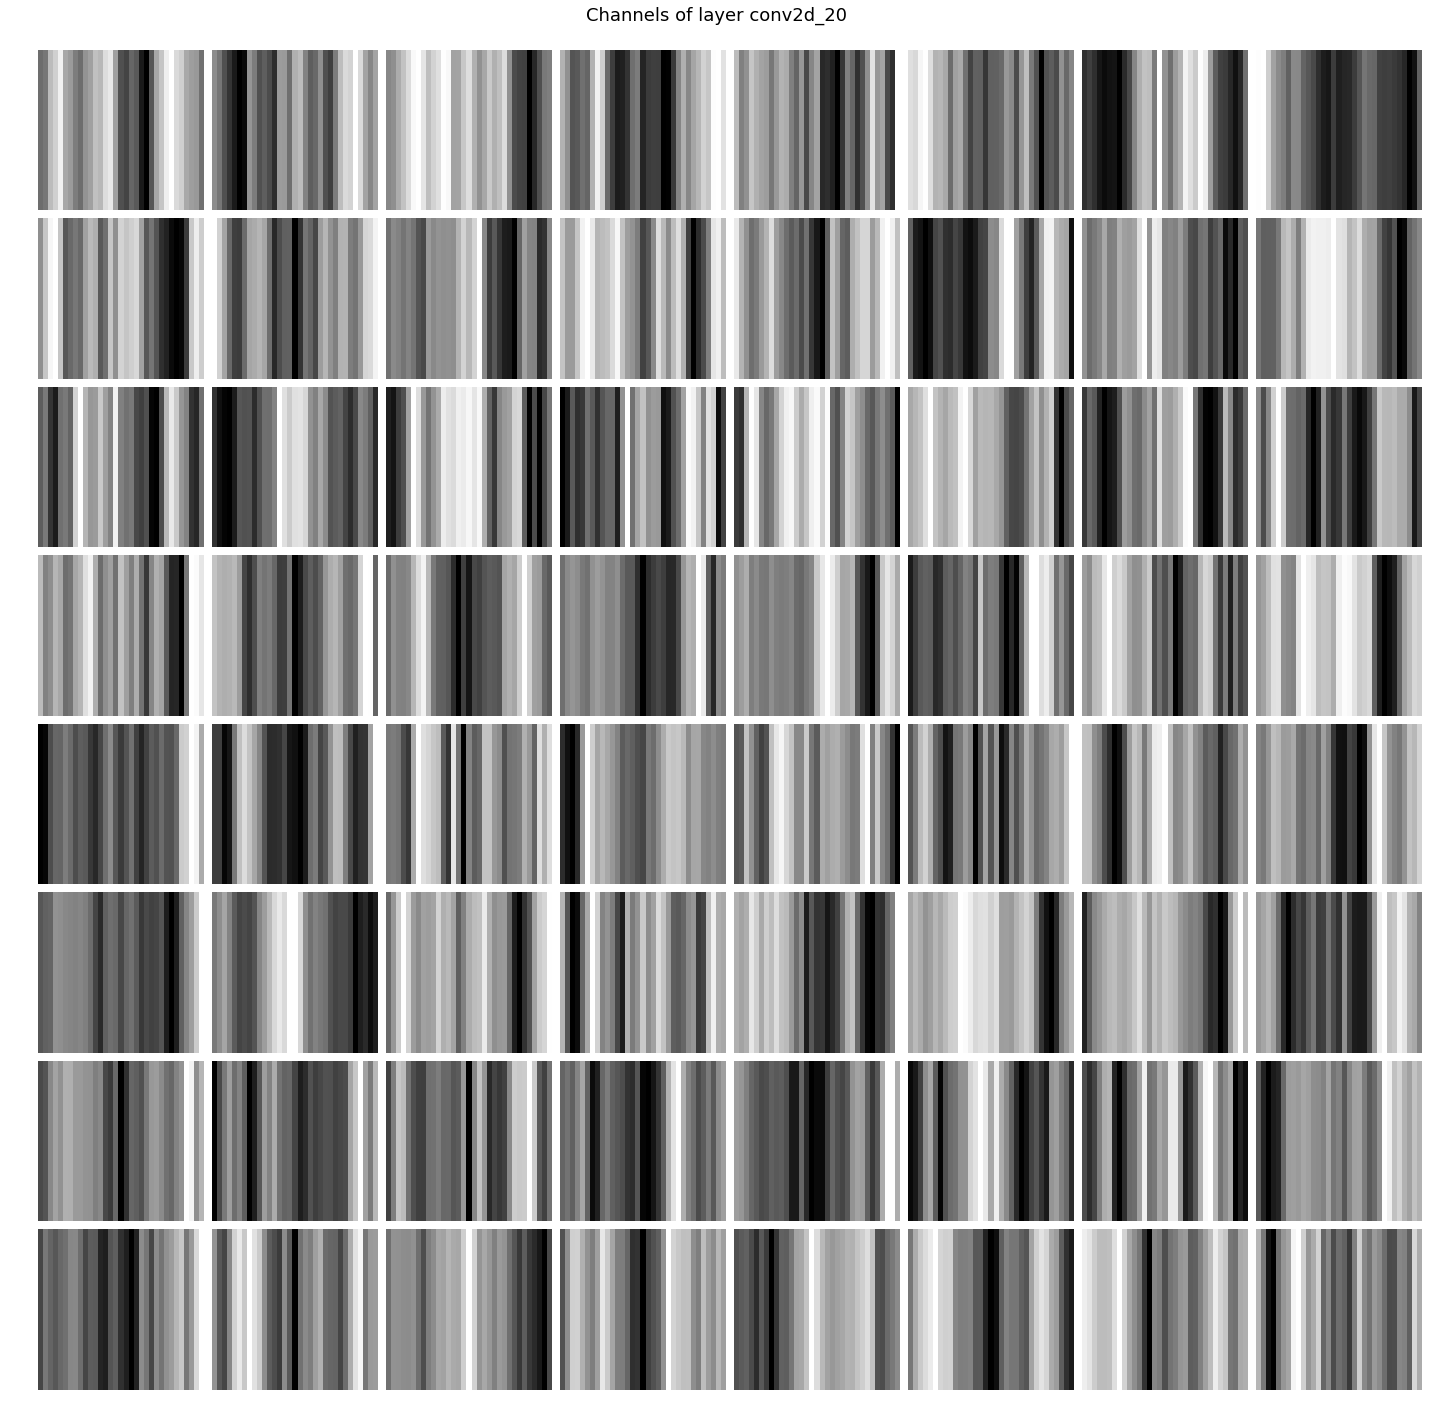

In [112]:
plot_layers(test_image, evaluation_functions)